# Object Tracking: 2-D Object Tracking using Kalman Filter in Python
We’re going to focus on 2-D Kalman Filter. The equations of 2-D Kalman Filter whose position and velocity must be considered in 2-dimensional direction, the x– and y– directions, can be created by modifying the 1-D Kalman Filter equations. Meaning that instead of considering only for the position and velocity in one direction, let’s say the x-direction, we need to take into account the position and velocity in the y-direction as well. 

The state in time k can be predicted by the previous state in time k-1. Let x and y be the positions in the x– and y-directions, respectively, and also let $\dot x$ and $\dot y$ be the velocities in x– and y-directions, respectively. Then the 2-D Kinematic equation for state $\textbf{x}_k$ can be written as:
  
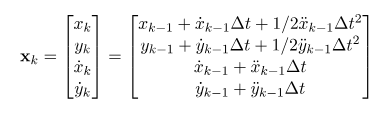           -----(1)


We can write eq.(1) into the form of matrix multiplication as follows:  
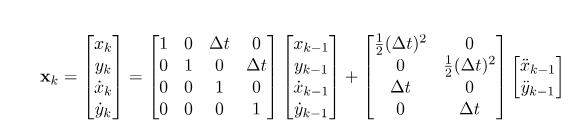      -----(2)

The eq.(2) can be simplified as follows:    
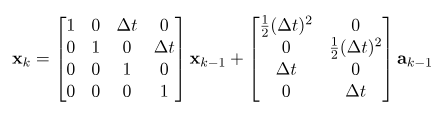      -----(3)

Where $\textbf{x}_k$ is the current state, $\textbf{x}_{k-1}$ is the previous state, and $\textbf{a}_ {k-1}$ is a vector of the previous acceleration in x– and y-directions.

So, we the matrices A and B as follows:  
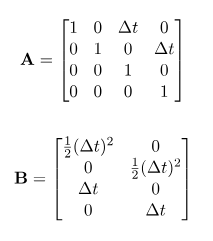


## Transformation matrix H 
The measurement model for 2-D Kalman filter is the same as the 1-D Kalman filter model:
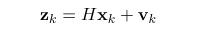  

In deriving the observation model, we assume that we’re only measuring the position but not the velocity. Whereas, there are cases where the velocity must be taken into account to incorporate Doppler’s effect, for example, airplane and satellite tracking systems.

We’re now considering the particular case where the velocity will not be considered in the measurement process. So, we can write the measurement model as follows:

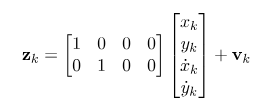  
  

So, we have the transformation matrix H as:  

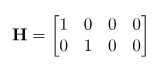  


## Process noise covariance matrix Q
The process noise covariance matrix Q for 2-D Kalman filter can be written as:  
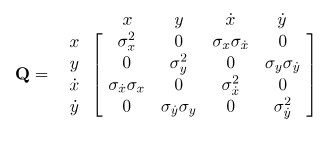  

we can rewrite the process noise covariance matrix for 2-D Kalman filter as:   
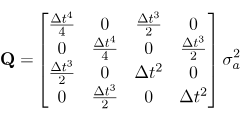  

Where the $\sigma_a$ is the magnitude of the standard deviation of the acceleration that is basically the process noise effecting on the process noise covariance matrix. 

## Measurement noise covariance matrix R

In 2-D Kalman filter, we suppose that the measurement positions x and y are both independent, so we can ignore any interaction between them so that the covariance x and y is 0. We look at only the variance in the x and the variance in the y.

Then, the measurement noise covariance R can be written as follows:

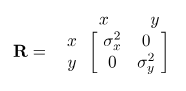  
Great! We have discussed the essential concepts of 2-D Kalman filter, and now it’s time to implement it in Python. Let’s do it! 

## Kalman Filter Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter(object):
    def __init__(self, dt, u_x,u_y, std_acc, x_std_meas, y_std_meas):
        """
        :param dt: sampling time (time for 1 cycle)
        :param u_x: acceleration in x-direction
        :param u_y: acceleration in y-direction
        :param std_acc: process noise magnitude
        :param x_std_meas: standard deviation of the measurement in x-direction
        :param y_std_meas: standard deviation of the measurement in y-direction
        """

        # Define sampling time
        self.dt = dt

        # Define the  control input variables
        self.u = np.matrix([[u_x],[u_y]])

        # Intial State
        self.x = np.matrix([[0], [0], [0], [0]])

        # Define the State Transition Matrix A
        self.A = np.matrix([[1, 0, self.dt, 0],
                            [0, 1, 0, self.dt],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

        # Define the Control Input Matrix B
        self.B = np.matrix([[(self.dt**2)/2, 0],
                            [0,(self.dt**2)/2],
                            [self.dt,0],
                            [0,self.dt]])

        # Define Measurement Mapping Matrix
        self.H = np.matrix([[1, 0, 0, 0],
                            [0, 1, 0, 0]])

        #Initial Process Noise Covariance
        self.Q = np.matrix([[(self.dt**4)/4, 0, (self.dt**3)/2, 0],
                            [0, (self.dt**4)/4, 0, (self.dt**3)/2],
                            [(self.dt**3)/2, 0, self.dt**2, 0],
                            [0, (self.dt**3)/2, 0, self.dt**2]]) * std_acc**2

        #Initial Measurement Noise Covariance
        self.R = np.matrix([[x_std_meas**2,0],
                           [0, y_std_meas**2]])

        #Initial Covariance Matrix
        self.P = np.eye(self.A.shape[1])

    def predict(self):
        # Refer to :Eq.(9) and Eq.(10)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795

        # Update time state
        #x_k =Ax_(k-1) + Bu_(k-1)     Eq.(9)
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)

        # Calculate error covariance
        # P= A*P*A' + Q               Eq.(10)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x[0:2]

    def update(self, z):

        # Refer to :Eq.(11), Eq.(12) and Eq.(13)  in https://machinelearningspace.com/object-tracking-simple-implementation-of-kalman-filter-in-python/?preview_id=1364&preview_nonce=52f6f1262e&preview=true&_thumbnail_id=1795
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R

        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  #Eq.(11)

        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))   #Eq.(12)

        I = np.eye(self.H.shape[1])

        # Update error covariance matrix
        self.P = (I - (K * self.H)) * self.P   #Eq.(13)
        return self.x[0:2]



## Detector

In [2]:
import cv2


def detect(frame,debugMode):
    # Convert frame from BGR to GRAY
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if (debugMode):
        cv2.imshow('gray', gray)

    # Edge detection using Canny function
    img_edges = cv2.Canny(gray,  50, 190, 3)
    if (debugMode):
        cv2.imshow('img_edges', img_edges)

    # Convert to black and white image
    ret, img_thresh = cv2.threshold(img_edges, 254, 255,cv2.THRESH_BINARY)
    if (debugMode):
        cv2.imshow('img_thresh', img_thresh)

    # Find contours
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Set the accepted minimum & maximum radius of a detected object
    min_radius_thresh= 3
    max_radius_thresh= 30

    centers=[]
    for c in contours:
        # ref: https://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html
        (x, y), radius = cv2.minEnclosingCircle(c)
        radius = int(radius)

        #Take only the valid circle(s)
        if (radius > min_radius_thresh) and (radius < max_radius_thresh):
            centers.append(np.array([[x], [y]]))
    cv2.imshow('contours', img_thresh)
    return centers

## Main

In [17]:
import cv2

def main():
    # Create OpenCV video capture object
    VideoCap = cv2.VideoCapture('videos/ball.mp4')

    # Get video properties
    frame_width = int(VideoCap.get(3))  # Width
    frame_height = int(VideoCap.get(4))  # Height
    fps = int(VideoCap.get(cv2.CAP_PROP_FPS))  # Frames per second

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for AVI format
    out = cv2.VideoWriter('output.avi', fourcc, fps, (frame_width, frame_height))

    # Variable used to control the speed of reading the video
    ControlSpeedVar = 100  # Lowest: 1 - Highest: 100
    HiSpeed = 100

    # Create KalmanFilter object KF
    KF = KalmanFilter(0.1, 1, 1, 1, 0.1, 0.1)

    debugMode = 1

    while True:
        # Read frame
        ret, frame = VideoCap.read()
        if not ret:
            break  # Exit loop if video ends

        # Detect object
        centers = detect(frame, debugMode)

        # If centroids are detected then track them
        if len(centers) > 0:
            cx, cy = int(centers[0][0]), int(centers[0][1])  # Extract center coordinates

            # Define square size (side length = 20 pixels)
            side = 45

            # Draw a square (instead of a circle) for the detected object
            cv2.rectangle(frame, (cx - side // 2, cy - side // 2), (cx + side // 2, cy + side // 2), (0, 191, 255), 2)

            # Predict
            (x, y) = KF.predict()
            cv2.rectangle(frame, (int(x - side // 2), int(y - side // 2)), (int(x + side // 2), int(y + side // 2)), (255, 0, 0), 2)

            # Update
            (x1, y1) = KF.update(centers[0])
            cv2.rectangle(frame, (int(x1 - side // 2), int(y1 - side // 2)), (int(x1 + side // 2), int(y1 + side // 2)), (0, 0, 255), 2)

            cv2.putText(frame, "Estimated Position", (int(x1 + side), int(y1 + 10)), 0, 0.5, (0, 0, 255), 2)
            cv2.putText(frame, "Predicted Position", (int(x + side), int(y)), 0, 0.5, (255, 0, 0), 2)
            cv2.putText(frame, "Measured Position", (cx + side, cy - side), 0, 0.5, (0, 191, 255), 2)

        # Write frame to output video
        out.write(frame)

        # Show frame
        cv2.imshow('image', frame)

        if cv2.waitKey(2) & 0xFF == ord('q'):
            break

        cv2.waitKey(HiSpeed - ControlSpeedVar + 1)

    # Release resources
    VideoCap.release()
    out.release()
    cv2.destroyAllWindows()


In [18]:
main()

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread (0x3b8ac80).
Cannot move to target thread (0x2aeb120)

QObject::moveToThread: Current thread (0x2aeb120) is not the object's thread